In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import h5py
import os
from datetime import datetime
from scipy.spatial import cKDTree

#### Here we open our H5 file in read mode and create a plotting function for plotting our data on the map.

In [2]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')
print("Overview of the file:")
for key in file.keys():
    print(key)

Overview of the file:
CSTPD
NetGen
Pgeneration
average_CSTPD
coordinates
energy_deficit
percentile_rank_of_seasonal_variability
percentile_rank_of_wind_power_density
stored_energy
time_index


In [2]:
def plot_data(file, data, labels, title, color, timestep=None): 
    coordinates = file['coordinates'][:]
    latitudes, longitudes = zip(*coordinates)

    if timestep is not None:
        values = file[data][timestep]
        timestamp = file['time_index'][timestep]
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()

        sc = plt.scatter(longitudes, latitudes, c=values, transform=ccrs.PlateCarree(), cmap=color)
        plt.colorbar(sc, label=labels)
        timestamp_str = timestamp.decode('utf-8')
        plt.title(f"Timestamp: {timestamp_str}")
    else:
        values = file[data][:]
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()

        sc = plt.scatter(longitudes, latitudes, c=values, transform=ccrs.PlateCarree(), cmap=color)
        plt.colorbar(sc, label=labels)
        plt.title(title)

    plt.show()
    file.close()

#### Wind Speed

We plot an example timestep for an example year to visualize the wind speed. Note that this is before we unscaled the data, so that technically everything is in cm/s.

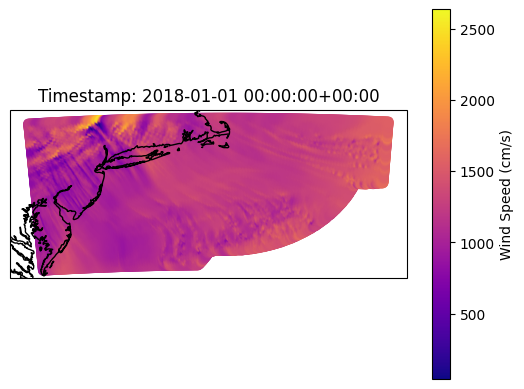

In [7]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_2018_160m.h5', 'r')
plot_data(file, 'windspeed_160m', 'Wind Speed (cm/s)', '', 'plasma', 0)

#### Turbine power

This visualize the turbine power in the climatological seasonal year.

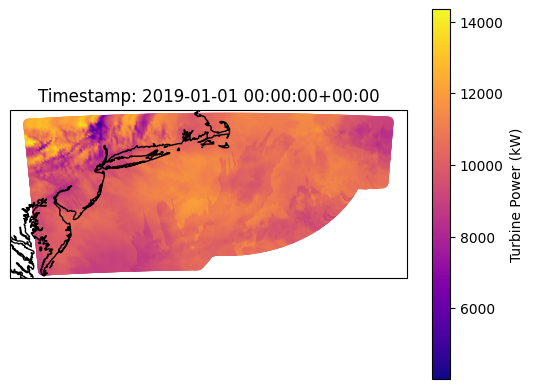

In [9]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')
plot_data(file, 'CSTPD', 'Turbine Power (kW)', '', 'plasma', 0)

### Adundance

This visualizes the 21-year average turbine power output for every location. 

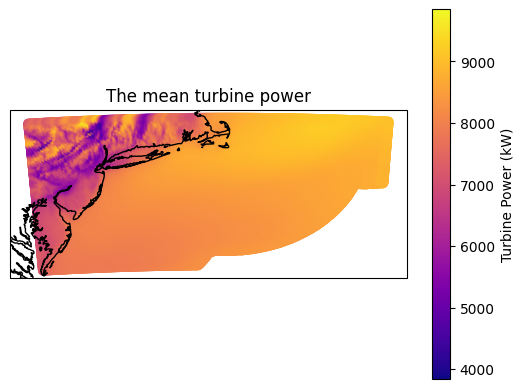

In [4]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')
plot_data(file, 'average_CSTPD', 'Turbine Power (kW)', 'The mean turbine power', 'plasma')

And we can divide this by the rated power to produce a capacity factor map. Here, we'll plot also two locations of equal capacity factor, these locations have different reliability factor, but that is not visible on this map. The reason for this is stated in the paper and the process to locate the coordinates are written in the analysis part of the notebook. 

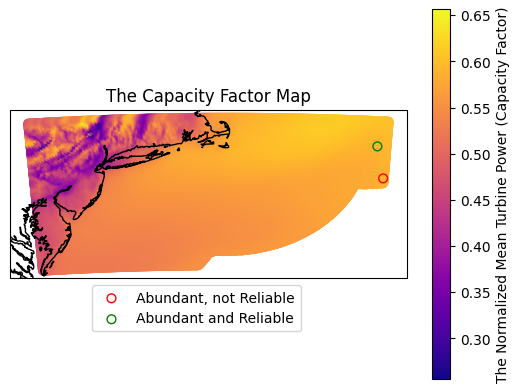

In [ ]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')

CF = file['average_CSTPD'][:] / 15000

coordinates = file['coordinates'][:]
latitudes, longitudes = zip(*coordinates)

highlight_coords = [
    (40.251667, -64.98013),
    (41.28321, -65.16632),
]
highlight_labels = [
    'Abundant, not Reliable',
    'Abundant and Reliable'
]

edge_colors=['red', 'green']

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

sc = plt.scatter(longitudes, latitudes, c=CF, transform=ccrs.PlateCarree(), cmap='plasma')

for coord, label, edgecolor in zip(highlight_coords, highlight_labels, edge_colors):
    plt.scatter(coord[1], coord[0], s=40, label=label, transform=ccrs.PlateCarree(), marker='o', edgecolors=edgecolor, facecolors='none')

plt.colorbar(sc, label='The Normalized Mean Turbine Power (Capacity Factor)')

plt.title(f"The Capacity Factor Map")

plt.legend(bbox_to_anchor=(0.75, 0))

#plt.savefig('Capacity Factor Map.png')

file.close()

### Variability

#### NetGen

Here, we could visualize the Net Gen for a timestep in our averaged year.

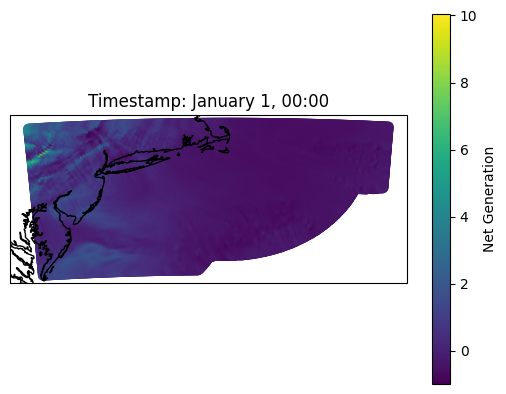

In [26]:
plot_data(file, 'NetGen', 0, 'Net Generation', 'Timestamp: January 1, 00:00')

Or it's behavior over a year at one grid cell. 

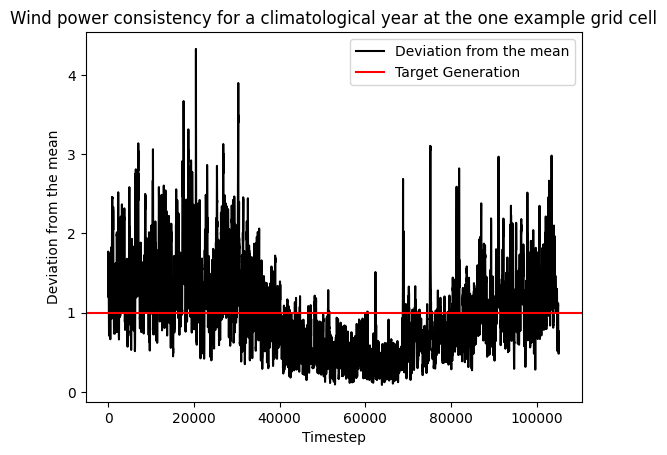

In [ ]:
plt.plot(file['Pgeneration'][:, 0], label = "Deviation from the mean", color = 'black')
plt.xlabel('Timestep')
plt.ylabel('Deviation from the mean')
plt.axhline(y=1, color='r', linestyle='-', label = "Target Generation")
plt.title('Wind power consistency for a climatological year at the one example grid cell')
plt.legend()
plt.show()

#### Stored Energy

We visualize the stored energy, or how the cummulative energy change over the course of a year for one grid cell. The maximum difference of all the local minima and local maxima pairs here will determine the variability or realibility of a cell.

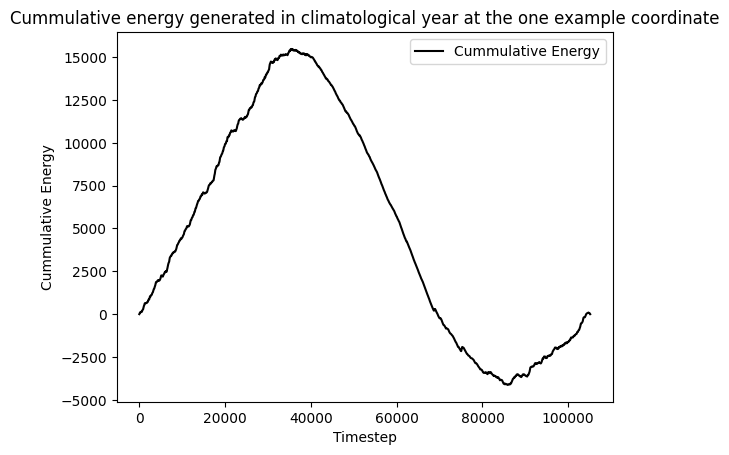

In [9]:
plt.plot(file['stored_energy'][:, 0], label = "Cummulative Energy", color = 'black')
plt.xlabel('Timestep')
plt.ylabel('Cummulative Energy')
plt.title('Cummulative energy generated in climatological year at the one example coordinate')
plt.legend()
plt.show()

Here we visualie the final variability plot.

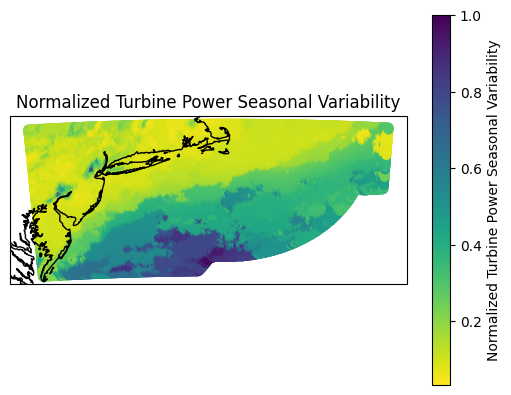

In [ ]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')

energy_deficit = file['energy_deficit']
normalized_energy_deficit = energy_deficit / (np.max(energy_deficit))

coordinates = file['coordinates'][:]
latitudes, longitudes = zip(*coordinates)

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

sc = plt.scatter(longitudes, latitudes, c=normalized_energy_deficit, transform=ccrs.PlateCarree(), cmap='viridis_r')

plt.colorbar(sc, label='Normalized Turbine Power Seasonal Variability')

plt.title(f"Normalized Turbine Power Seasonal Variability")

plt.show()
file.close()

The reliability plot is the reverse ranking of the variability found above. 

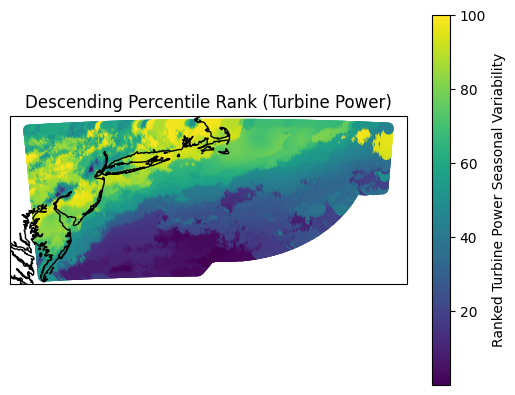

In [ ]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')

percentile_rank_of_seasonal_variability = file['percentile_rank_of_seasonal_variability'][:]

coordinates = file['coordinates'][:]
latitudes, longitudes = zip(*coordinates)

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

sc = plt.scatter(longitudes, latitudes, c=percentile_rank_of_seasonal_variability, transform=ccrs.PlateCarree(), cmap='viridis')

plt.colorbar(sc, label='Ranked Turbine Power Seasonal Variability')

plt.title(f"Descending Percentile Rank (Turbine Power)")

plt.show()
file.close()

# Abundant and reliable

Here, we use the minimum percentile rank method to combine the two maps. 

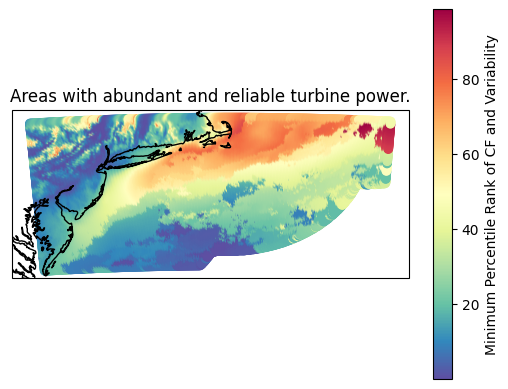

In [ ]:
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')

percentile_rank_of_wind_power_density = file['percentile_rank_of_wind_power_density'][:]
percentile_rank_of_seasonal_variability = file['percentile_rank_of_seasonal_variability'][:]

minimum_percentile_rank = np.minimum(percentile_rank_of_wind_power_density, percentile_rank_of_seasonal_variability)

coordinates = file['coordinates'][:]
latitudes, longitudes = zip(*coordinates)

ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

sc = plt.scatter(longitudes, latitudes, c=minimum_percentile_rank, transform=ccrs.PlateCarree(), cmap='Spectral_r')

plt.colorbar(sc, label='Minimum Percentile Rank of CF and Variability')

plt.title(f"Areas with abundant and reliable turbine power.")

plt.show()
file.close()

# Analysis

In [2]:
import pandas as pd
from tabulate import tabulate

We want to first filter out the points that are onshore

In [ ]:

offshore_coordinates_df = pd.read_csv('../data/Offshore Mid-Atlantic Coordinates.csv')
onshore_coordinates_df = pd.read_csv('../data/Onshore Mid-Atlantic Coordinates.csv')

# Convert the offshore coordinates to a NumPy array
offshore_coordinates = offshore_coordinates_df[['Latitude', 'Longitude']].to_numpy()
onshore_coordinates = onshore_coordinates_df[['Latitude', 'Longitude']].to_numpy()

# Open the HDF5 file
file = h5py.File(r'E:\\NOW23\\Mid_Atlantic_160m_TPC.h5', 'r')

# Read the coordinates dataset from the HDF5 file
coordinates = file['coordinates'][:]

# Create a KD-tree for the coordinates in the HDF5 file
tree = cKDTree(coordinates)

# Find the closest coordinates in the HDF5 file to the offshore coordinates
distances, indices = tree.query(offshore_coordinates, k=1)
onshore_distances, onshore_indices = tree.query(onshore_coordinates, k=1)

# print the offshore coordinates and their corresponding coordinates if you want to check
print(f'Offshore Coordinates: {offshore_coordinates}', f'Closest Coordinates: {coordinates[indices]}')

# Filter the datasets using the indices of the closest coordinates
offshore_coordinates_filtered = coordinates[indices]
onshore_coordinates_filtered = coordinates[onshore_indices]

percentile_rank_of_wind_power_density = file['percentile_rank_of_wind_power_density'][indices]
percentile_rank_of_seasonal_variability = file['percentile_rank_of_seasonal_variability'][indices]
onshore_percentile_rank_of_wind_power_density = file['percentile_rank_of_wind_power_density'][onshore_indices]
onshore_percentile_rank_of_seasonal_variability = file['percentile_rank_of_seasonal_variability'][onshore_indices]

minimum_percentile_rank = np.minimum(percentile_rank_of_wind_power_density, percentile_rank_of_seasonal_variability)
onshore_minimum_percentile_rank = np.minimum(onshore_percentile_rank_of_wind_power_density, onshore_percentile_rank_of_seasonal_variability)

# Close the file
file.close()

Offshore Coordinates: [[ 37.474846 -75.96927 ]
 [ 37.493233 -75.97101 ]
 [ 37.511627 -75.97272 ]
 ...
 [ 42.048256 -64.80298 ]
 [ 42.066807 -64.80136 ]
 [ 42.085373 -64.79974 ]] Closest Coordinates: [[ 37.474846 -75.96927 ]
 [ 37.493233 -75.97101 ]
 [ 37.511627 -75.97272 ]
 ...
 [ 42.048256 -64.80298 ]
 [ 42.066807 -64.80136 ]
 [ 42.085373 -64.79974 ]]


### Two Dimension Matrix

Here we define five points and locate the grid cell with the closest values to each of the five points using Euclidean distance calculation. As specified in the paper, we do not use (0, 100) and (100, 100) to represent the best points closest to the corner. But instead a point with a similar x value as their no-reliability counterparts. 

In [ ]:
coordinates_rank = list(zip(offshore_coordinates_filtered, percentile_rank_of_wind_power_density, percentile_rank_of_seasonal_variability))

# Define the target coordinates in terms of mean_CSWPD and seasonal_variability
target_coordinates = [(0, 0), (16.5, 100), (50, 50), (100, 0), (85, 100)]

# Function to calculate Euclidean distance
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# Find the closest data points
closest_points = {}
for target in target_coordinates:
    min_distance = float('inf')
    closest_point = None
    for coordinate, mean_CSWPD, seasonal_variability in coordinates_rank:
        data_point = (mean_CSWPD, seasonal_variability)
        distance = euclidean_distance(data_point, target)
        if distance < min_distance:
            min_distance = distance
            closest_point = (coordinate, mean_CSWPD, seasonal_variability)
    closest_points[target] = closest_point

# Print the closest data points
for target, point in closest_points.items():
    coordinate, mean_CSWPD, seasonal_variability = point
    print(f'Target Coordinate: {target}, Closest Coordinate: {coordinate}, Abundance: {mean_CSWPD}, Variability: {seasonal_variability}')

Target Coordinate: (0, 0), Closest Coordinate: [ 37.658833 -75.98663 ], Abundance: 16.498540335867272, Variability: 7.07575801370061
Target Coordinate: (16.5, 100), Closest Coordinate: [ 41.227116 -72.75607 ], Abundance: 16.581399157923133, Variability: 99.49706621961441
Target Coordinate: (50, 50), Closest Coordinate: [ 39.462063 -72.8215  ], Abundance: 49.77791908739679, Variability: 51.601776647300824
Target Coordinate: (100, 0), Closest Coordinate: [ 40.251667 -64.98013 ], Abundance: 86.33889258220847, Variability: 14.297000703336513
Target Coordinate: (85, 100), Closest Coordinate: [ 41.28321 -65.16632], Abundance: 87.26190132092378, Variability: 96.13743002765172


We plot the abundance against the reliability to see the wind location patterns and also highlight the five selected points. 

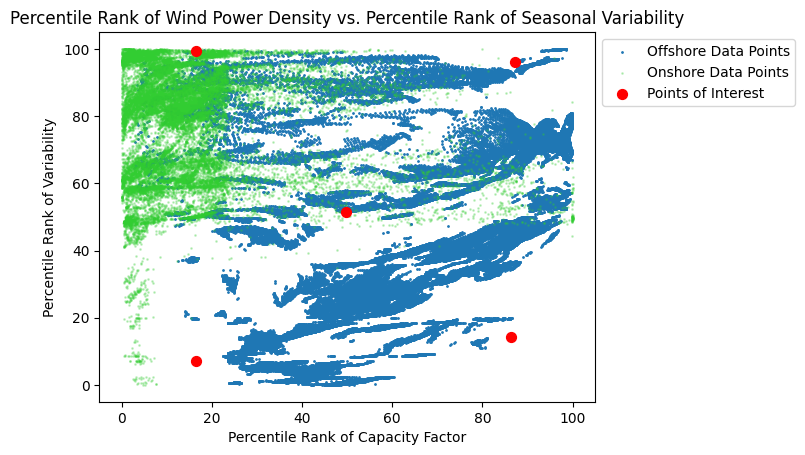

In [ ]:
highlight_values = [16.498540335867272, 16.581399157923133, 49.77791908739679, 86.33889258220847, 87.26190132092378]

highlight_indices = [i for i, val in enumerate(percentile_rank_of_wind_power_density) if val in highlight_values]

highlight_seasonal_variability = [percentile_rank_of_seasonal_variability[i] for i in highlight_indices]

highlight_wind_power_density = [percentile_rank_of_wind_power_density[i] for i in highlight_indices]

plt.scatter(percentile_rank_of_wind_power_density, percentile_rank_of_seasonal_variability, s=1, label='Offshore Data Points')
plt.scatter(onshore_percentile_rank_of_wind_power_density, onshore_percentile_rank_of_seasonal_variability, s=1, label='Onshore Data Points', color='limegreen', alpha=0.25)

plt.scatter(highlight_wind_power_density, highlight_seasonal_variability, color='red', s=50, label='Points of Interest')

plt.xlabel('Percentile Rank of Capacity Factor')
plt.ylabel('Percentile Rank of Variability')
plt.title('Percentile Rank of Wind Power Density vs. Percentile Rank of Seasonal Variability')
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

file.close()

# Retrieving Coordinate's Data

This is the step to retrieve the coordinate's data to be prepared for our optimization model. We used needed to use 2015 - 2019's data, but that could be changed for other years. 

In [12]:
def calculate_power(wind_speeds):
    """
    Calculate the power output based on wind speeds.
    
    Parameters:
    wind_speeds (array-like): Array of wind speeds.
    
    Returns:
    np.ndarray: Array of power outputs.
    """
    wind_speeds = np.array(wind_speeds)
    power_output = np.zeros_like(wind_speeds)
    
    # Apply the polynomial fit for wind speeds between 4 and 11 m/s
    mask_4_to_11 = (wind_speeds >= 4) & (wind_speeds <= 11)
    power_output[mask_4_to_11] = polynomial(wind_speeds[mask_4_to_11])
    
    # Set power to 0 for wind speeds less than 4 m/s
    mask_less_than_4 = wind_speeds < 4
    power_output[mask_less_than_4] = 0
    
    # Set power to 15000 for wind speeds between 11 and 25 m/s
    mask_11_to_25 = (wind_speeds > 11) & (wind_speeds <= 25)
    power_output[mask_11_to_25] = 15000

    power_output[wind_speeds > 25] = 0

    power_output = power_output / power_output.max()
    
    return power_output

Windspeed data for coordinate [41.227116, -72.75607]:
[118.2740881  118.88903014 124.5197016  ... 254.2860733  224.8252888
 193.44051011]
Data for year 2015:
                        Timestamp  Windspeed
0       2015-01-01 00:00:00+00:00       5.78
12      2015-01-01 01:00:00+00:00       6.32
24      2015-01-01 02:00:00+00:00       6.16
36      2015-01-01 03:00:00+00:00       8.94
48      2015-01-01 04:00:00+00:00      11.51
...                           ...        ...
105060  2015-12-31 19:00:00+00:00       7.21
105072  2015-12-31 20:00:00+00:00       6.35
105084  2015-12-31 21:00:00+00:00       8.53
105096  2015-12-31 22:00:00+00:00       8.90
105108  2015-12-31 23:00:00+00:00       8.73

[8760 rows x 2 columns]
Windspeed data for coordinate [41.227116, -72.75607]:
[ 257.36622126  240.2366904   233.41035156 ... 4682.7909625  4590.69637696
 4520.68188784]
Data for year 2016:
                        Timestamp  Windspeed
0       2016-01-01 00:00:00+00:00       7.49
12      2016-01-01 01:

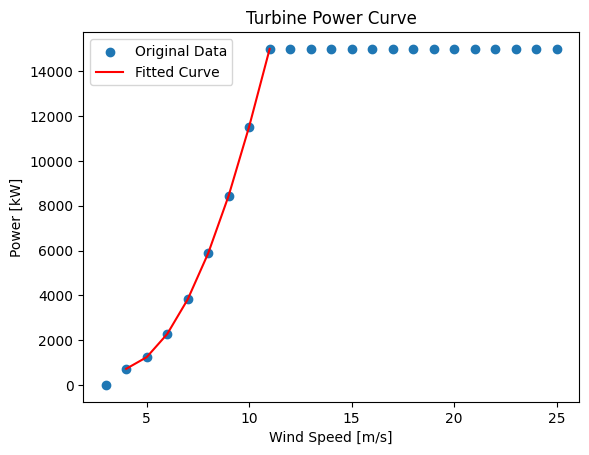

Wind Speeds: [5.78 6.32 6.16 ... 7.46 8.2  6.98]
Power Output: [0.13400651 0.18139644 0.16633983 ... 0.31341915 0.42234639 0.25254117]
Capacity Factor: 0.49039876682393935


In [ ]:
def find_coordinate_index(coordinates, target_coordinate):
    for i, coord in enumerate(coordinates):
        if np.allclose(coord, target_coordinate):
            return i
    raise ValueError("Coordinate not found in the dataset")

target_coordinate = [41.227116, -72.75607]

for year in range(2015, 2019 + 1):
    file_path = f'E:\\NOW23\\Mid_Atlantic_{year}_160m.h5'
    file = h5py.File(file_path, 'r')

    coordinates = file['coordinates'][:]

    coordinate_index = find_coordinate_index(coordinates, target_coordinate)

    windspeed_data = file['power_density'][:, coordinate_index]

    timestamps = file['time_index'][:]

    data = {'Timestamp': timestamps, 'Windspeed': windspeed_data}

    file.close()

    df = pd.DataFrame(data)
    df['Timestamp'] = df['Timestamp'].str.decode('utf-8')

    df = df[df['Timestamp'].str.endswith(':00:00+00:00')]

    df['Windspeed'] = (df['Windspeed'] * 2 / 1.225) ** (1/3)

    print(f"Data for year {year}:")
    print(df)

    output_file = f'windspeed_{year}.csv'
    df.to_csv(output_file, index=False)

df_2015 = pd.read_csv('windspeed_2015.csv')
df_2016 = pd.read_csv('windspeed_2016.csv')
df_2017 = pd.read_csv('windspeed_2017.csv')
df_2018 = pd.read_csv('windspeed_2018.csv')
df_2019 = pd.read_csv('windspeed_2019.csv')

df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019])

df.to_csv('windspeed.csv', index=False)

os.remove('windspeed_2015.csv')
os.remove('windspeed_2016.csv')
os.remove('windspeed_2017.csv')
os.remove('windspeed_2018.csv')
os.remove('windspeed_2019.csv')

data = pd.read_csv('./windspeed.csv')

turbine_curve = pd.read_csv('../data/2020ATB_NREL_Reference_15MW_240.csv')

mask = (turbine_curve['Wind Speed [m/s]'] >= 4) & (turbine_curve['Wind Speed [m/s]'] <= 11)
wind_speed_filtered = turbine_curve['Wind Speed [m/s]'][mask]
power_filtered = turbine_curve['Power [kW]'][mask]

coefficients = np.polyfit(wind_speed_filtered, power_filtered, degree)
polynomial = np.poly1d(coefficients)

plt.scatter(turbine_curve['Wind Speed [m/s]'], turbine_curve['Power [kW]'], label='Original Data')
plt.plot(wind_speed_filtered, power_filtered, color='red', label='Fitted Curve')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Power [kW]')
plt.title('Turbine Power Curve')
plt.legend()
plt.show()

wind_speeds = np.array(data['Windspeed'])
power_output = calculate_power(wind_speeds)
print("Wind Speeds:", wind_speeds)
print("Power Output:", power_output)
print("Capacity Factor:", power_output.mean())

In [ ]:
offshore_data = pd.read_csv('./offshore_power_hourly_norm.csv')
offshore_data['offshore.pot.node3'] = power_output
offshore_data['offshore.pot.node4'] = power_output
offshore_data.to_csv('../sectr-ny/data_uploads/offshore_power_hourly_norm.csv', index=False)